In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_embed_tim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(t_embed_tim, in_channels),
            nn.ReLU(),
            nn.Linear(in_channels, in_channels)
        )
    
    def forward(self, x, v):
        N, C = x.shape[:2]
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

In [13]:
def _pos_encoding(t, output_dim, device="cpu"):
    D = output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = 10000 ** (i / D)

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])

    return v


def pos_encoding(ts, output_dim, device="cpu"):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    
    return v

In [14]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, t_embed_dim=100):
        super().__init__()
        self.down1 = ConvBlock(in_channels, 64, t_embed_tim=t_embed_dim)
        self.down2 = ConvBlock(64, 128, t_embed_tim=t_embed_dim)
        self.bot1 = ConvBlock(128, 256, t_embed_tim=t_embed_dim)

        self.up2 = ConvBlock(128 + 256, 128, t_embed_tim=t_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, t_embed_tim=t_embed_dim)
        self.out = nn.Conv2d(64, in_channels, kernel_size=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")

        self.t_embed_dim = t_embed_dim
    
    def forward(self, x, ts):
        v = pos_encoding(ts, self.t_embed_dim, x.device)

        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)

        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)

        return x

In [15]:
class Diffuser(nn.Module):
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device="cpu"):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.device = device

        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        t_idx = T - 1

        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar = alpha_bar.view(-1, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise
    
    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        t_idx = T - 1

        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx - 1]

        alpha = alpha.view(-1, 1, 1, 1)
        alpha_bar = alpha_bar.view(-1, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(-1, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        noise = torch.rand_like(x, device=self.device)
        noise[t == 1] = 0.0

        mu = (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) / (1 - alpha_bar))

        return mu + noise * std
    
    def reverse_to_img(self, x):
        x *= 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)
    
    def sample(self, model, x_shape=(16, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t)
        
        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images

In [16]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = "cpu"

In [17]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root="../../data/mnist", download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
diffuser = Diffuser(num_timesteps, device=device)

In [19]:
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model

UNet(
  (down1): ConvBlock(
    (convs): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (mlp): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1, out_features=1, bias=True)
    )
  )
  (down2): ConvBlock(
    (convs): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [20]:
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")

    for images, labels in pbar:
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        loss_sum += batch_loss
        cnt += 1
        avg_loss = loss_sum / cnt
        losses.append(batch_loss)

        pbar.set_postfix(loss=f"{batch_loss:.4f}", avg=f"{avg_loss:.4f}")

Epoch 10/10: 100%|██████████| 469/469 [05:12<00:00,  1.50it/s, avg=0.0002, loss=0.0002]


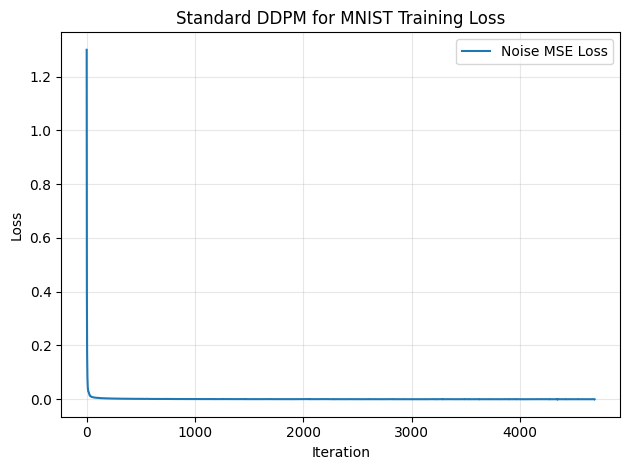

In [24]:
plt.plot(losses, label="Noise MSE Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Standard DDPM for MNIST Training Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

In [22]:
def show_images(images, rows=2, cols=8):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for _ in range(rows):
        for _ in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap="gray")
            plt.axis("off")
            i += 1
    
    fig.tight_layout()
    return fig

100%|██████████| 1000/1000 [00:27<00:00, 36.43it/s]


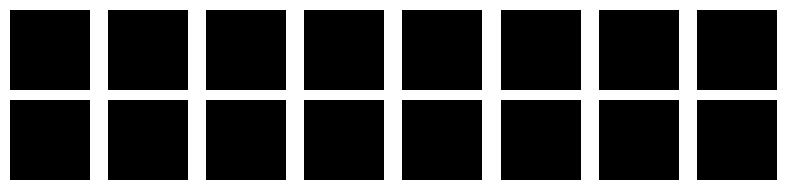

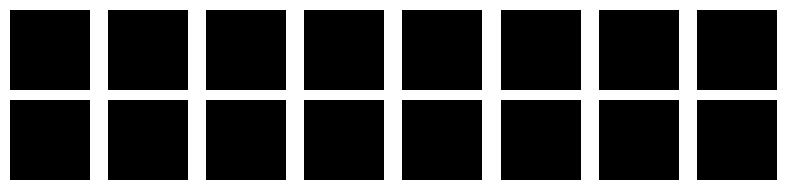

In [23]:
images = diffuser.sample(model)
show_images(images)